# Setup & Config

In [1]:
!rm -r /kaggle/working/*
%cd /kaggle/working

/kaggle/working


## Kaggle Environment

In [2]:
import os
from tqdm import tqdm

KAGGLE_ENV = not os.path.exists("/kaggle/.vscode")
ENV_NAME = "kaggle" if KAGGLE_ENV else "local"
print(f"{KAGGLE_ENV=}")
print(f"{ENV_NAME=}")

if KAGGLE_ENV:
    !pip install -U -q plyvel --no-index --find-links=file:///kaggle/input/uspto-gen-wheel/plyvel

    move_dirs = (
        [
        "/kaggle/input/preprocess-all-token-single",
        "/kaggle/input/uspto-rare-tokens-dataset",
        ] 
        + [f"/kaggle/input/complete-db-{i}" for i in range(15)]
        + [f"/kaggle/input/complete-db-v2-{i}" for i in range(5)]
        + [f"/kaggle/input/uspto-ratio-db-{i}" for i in range(20)]
    )

    !mkdir /kaggle/tmp
    for move_dir in tqdm(move_dirs):
        !cp -r {move_dir} /kaggle/tmp/{move_dir.split("/")[-1]}
    !ls /kaggle/tmp

KAGGLE_ENV=False
ENV_NAME='local'


## Load Library

In [3]:
import os
import sys

if KAGGLE_ENV:
    PACKAGE_DIR = "/kaggle/input/uspto-src/src"
else:
    PACKAGE_DIR = "/kaggle/src"
sys.path.append(PACKAGE_DIR)
sys.path.append(os.path.join(PACKAGE_DIR, "Penguin-ML-Library"))

In [4]:
import json
import multiprocessing
import random
import warnings
from collections import Counter
from typing import List, Set, Tuple

import matplotlib.pyplot as plt
import numpy as np
import plyvel
import polars as pl
import yaml
from penguinml.utils.logger import get_logger, init_logger
from penguinml.utils.set_seed import seed_base
from penguinml.utils.timer import Timer
from tqdm import tqdm

import whoosh_utils
from const import INF, NUM_CPU
from db import CompleteDB, SingleTokenDB
from solver import HitBlock, SimulatedAnnealing, State
from utils import compute_ap, evaluate

warnings.filterwarnings("ignore")
MODEL_NAME = "baseline"
CFG = yaml.safe_load(open(os.path.join(PACKAGE_DIR, "config.yaml"), "r"))
print(CFG[MODEL_NAME]["execution"]["exp_id"])
CFG["output_dir"] = f"/kaggle/output/{CFG[MODEL_NAME]['execution']['exp_id']}"
# !rm -r {CFG["output_dir"]}
os.makedirs(CFG["output_dir"], exist_ok=True)

init_logger("log.log")
logger = get_logger("main")
seed_base(CFG[MODEL_NAME]["execution"]["seed"])

2024-07-27 16:35:26.916062: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-27 16:35:27.486771: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-27 16:35:28.505370: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/u

Processing /kaggle/input/whoosh-wheel-2-7-4/Whoosh-2.7.4-py2.py3-none-any.whl
Whoosh is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


set seed: 46


exp_0001


## Dataset Preparation

In [5]:
DANGER_TYPE = "all"
# DANGER_TYPE = "2hop"
assert DANGER_TYPE in ["all", "2hop"]

if KAGGLE_ENV:
    TRAIN_PATH = "/kaggle/input/uspto-train-index-2500/train2500_seed0.parquet"
    #     TRAIN_PATH = "/kaggle/input/uspto-explainable-ai/test.csv"
    TRAIN_INDEX_PATH = "/kaggle/input/uspto-train-index-2500/index_2500_200k"
    NN_DF_PATH = "/kaggle/input/uspto-explainable-ai/nearest_neighbors.csv"

    # database
    PATENT2RARE_TOKENS_PATH = "/kaggle/tmp/uspto-rare-tokens-dataset/db"

    COMPLETE_DB_PATH = [f"/kaggle/tmp/complete-db-{i}/complete-db-{i}/db" for i in range(15)]
    COMPLETE_INDEX_PATH = [f"/kaggle/input/uspto-complete-index-{i}/index.lz4" for i in range(15)]

    COMPLETE_DB_V2_PATH = [f"/kaggle/tmp/complete-db-v2-{i}/db" for i in range(5)]
    COMPLETE_INDEX_V2_PATH = [f"/kaggle/input/complete-db-index-v2-{i}/index.lz4" for i in range(5)]

    SINGLE_TOKEN_DB_PATH = "/kaggle/tmp/preprocess-all-token-single/db/db"
    SINGLE_TOKEN_INDEX_PATH = "/kaggle/tmp/preprocess-all-token-single/index.lz4"

    TRAIN_MODE = "train" in TRAIN_PATH
    VISUALIZE = False
else:
    TRAIN_PATH = "/kaggle/input/uspto-train-data-2500/train2500_seed0.parquet"
    # TRAIN_INDEX_PATH = "/kaggle/input/train-index-2500/index_2500_200k"
    TRAIN_INDEX_PATH = "/kaggle/input/train-index-difficult/index_2500_1M"
    NN_DF_PATH = "/kaggle/input/uspto-boolean-search-optimization/nearest_neighbors.csv"

    # database
    PATENT2RARE_TOKENS_PATH = "/kaggle/input/rare-tokens/db"

    COMPLETE_DB_PATH = [
        f"/kaggle/input/preprocess-complete/split/complete-db-{i}/db" for i in range(15)
    ]
    COMPLETE_INDEX_PATH = [
        f"/kaggle/input/preprocess-complete/split/complete-db-{i}/index.lz4" for i in range(15)
    ]

    COMPLETE_DB_V2_PATH = [
        f"/kaggle/input/preprocess-complete-v2/split/complete-db-{i}/db" for i in range(5)
    ]
    COMPLETE_INDEX_V2_PATH = [
        f"/kaggle/input/preprocess-complete-v2/split/complete-db-{i}/index.lz4" for i in range(5)
    ]

    COMPLETE_DB_V3_PATH = [
        f"/kaggle/input/preprocess-complete-v3/split/complete-db-{i}/db" for i in range(2)
    ]
    COMPLETE_INDEX_V3_PATH = [
        f"/kaggle/input/preprocess-complete-v3/split/complete-db-{i}/index.lz4" for i in range(2)
    ]

    SINGLE_TOKEN_DB_PATH = "/kaggle/input/preprocess-all-token-single/db"
    SINGLE_TOKEN_INDEX_PATH = "/kaggle/input/preprocess-all-token-single/index.lz4"

    SINGLE_TOKEN_DB_V2_PATH = "/kaggle/input/preprocess-all-token-single-v2/db"
    SINGLE_TOKEN_INDEX_V2_PATH = "/kaggle/input/preprocess-all-token-single-v2/index.lz4"

    TRAIN_MODE = True
    VISUALIZE = False

In [6]:
if TRAIN_PATH.split(".")[-1] == "parquet":
    train = pl.read_parquet(TRAIN_PATH)
else:
    train = pl.read_csv(TRAIN_PATH)

if TRAIN_MODE:
    train = train.filter(~train["publication_number"].str.starts_with("US-D"))

all_patents = []
for i in range(50):
    all_patents += train[f"target_{i}"].to_list()
all_patents = set(all_patents)

if DANGER_TYPE == "2hop":
    all_df = pl.read_csv(NN_DF_PATH)
    all_df = all_df.filter(all_df["publication_number"].is_in(all_patents))
    for i in range(50):
        all_patents.update(all_df[f"neighbor_{i}"].to_list())
print(len(all_patents))

if TRAIN_MODE:
    train = train.head(300)
train.head(1)

113883


publication_number,target_0,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target_8,target_9,target_10,target_11,target_12,target_13,target_14,target_15,target_16,target_17,target_18,target_19,target_20,target_21,target_22,target_23,target_24,target_25,target_26,target_27,target_28,target_29,target_30,target_31,target_32,target_33,target_34,target_35,target_36,target_37,target_38,target_39,target_40,target_41,target_42,target_43,target_44,target_45,target_46,target_47,target_48,target_49
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""US-2011086809-…","""US-2006229256-…","""US-2009192226-…","""US-2023114071-…","""US-7754692-B2""","""US-9345727-B2""","""US-7829126-B2""","""US-2012171231-…","""US-2012171164-…","""US-2023140478-…","""US-2021138042-…","""US-9226914-B2""","""US-11389403-B2…","""US-2016029681-…","""US-10342244-B2…","""US-2021145782-…","""US-2007166411-…","""US-7867541-B2""","""US-10028519-B2…","""US-9386794-B2""","""US-2012171328-…","""US-2013338228-…","""US-2023102803-…","""US-10688070-B2…","""US-2014308393-…","""US-2016106799-…","""US-9370553-B2""","""US-2014303067-…","""US-9474766-B2""","""US-2015157048-…","""US-2018310605-…","""US-2023149542-…","""US-2017105445-…","""US-2011208153-…","""US-9345741-B2""","""US-2022386675-…","""US-2006229366-…","""US-9241923-B2""","""US-11606966-B2…","""US-2007202052-…","""US-2012171163-…","""US-2013230503-…","""US-2015305359-…","""US-2010179104-…","""US-2016015068-…","""US-2022233488-…","""US-2020230162-…","""US-2022168399-…","""US-9107894-B2""","""US-2023013644-…","""US-2014328970-…"


In [7]:
if TRAIN_MODE:
    train_idx = whoosh_utils.load_index(TRAIN_INDEX_PATH)
    searcher = whoosh_utils.get_searcher(train_idx)
    qp = whoosh_utils.get_query_parser()

In [8]:
patent2rare_tokens = plyvel.DB(PATENT2RARE_TOKENS_PATH, create_if_missing=False)

complete_db = CompleteDB(COMPLETE_DB_PATH, COMPLETE_INDEX_PATH)
complete_v2_db = CompleteDB(COMPLETE_DB_V2_PATH, COMPLETE_INDEX_V2_PATH)
single_token_db = SingleTokenDB(SINGLE_TOKEN_DB_PATH, SINGLE_TOKEN_INDEX_PATH)

---
# Main Part

In [9]:
def enumerate_token_queries(
    target_ids: List[str],
    center_id: str,
    top_k: int = 30,
) -> List[HitBlock]:
    """
    3. cpcを使わずにねじ込めるqueryを追加
    """
    cands = []
    # single patent
    for target_id in target_ids:
        data = patent2rare_tokens.get(target_id.encode())
        if data is None:
            continue
        rare_tokens = json.loads(data.decode())
        if rare_tokens is None or len(rare_tokens) == 0:
            continue

        if rare_tokens[0][0] == 1:
            score = -INF
            tokens = [rare_tokens[0][1]]
        else:
            score = 1
            tokens = []
            for freq, token in rare_tokens:
                score *= freq / 10_000_000
                tokens.append(token)
                if score < 1e-13:
                    break
        this_query = f"({' '.join(tokens)})"
        block = HitBlock(this_query, {target_id}, 1, 0, 0)
        cands.append((score, block))
    cands = sorted(cands, key=lambda x: x[0])[:top_k]
    cands = [cand[1] for cand in cands]

    # multi patents
    data = []
    d = single_token_db.get(center_id)
    if d is not None:
        data += d
    for token, n_inner, n_outer, pattents in data:
        if n_outer < 5:
            assert n_inner == len(pattents)
            block = HitBlock(f"({token})", set(pattents), n_inner, 0, n_outer)
            cands.append(block)
    return cands

In [10]:
def optimize(
    use_cpcs: List[str],
    query_patents: List[List[HitBlock]],
    center_id: str,
    target_ids: List[str],
) -> Tuple[str, int, float]:
    """最適化"""
    if TRAIN_MODE:
        timer = Timer()
        log = ""
        log_file = f"/kaggle/working/log/{center_id}.txt"
        os.makedirs(os.path.dirname(log_file), exist_ok=True)

    if TRAIN_MODE and VISUALIZE:
        visualize_log = {}

    state = State(use_cpcs, query_patents, target_ids)
    target2index = {target: [] for target in target_ids}
    for i, query_patent in enumerate(query_patents):
        for j, block in enumerate(query_patent):
            for target in block.inner_patents:
                target2index[target].append((i, j))

    global_best_state = state.copy()
    global_best_score = -INF
    global_best_query = ""
    global_best_hit_patent_count = 0
    global_best_ap = 0

    n_iter = 50000 * 1
    sa = SimulatedAnnealing(0.001, 0.00001, n_iter)

    best_score = -INF
    best_query = ""
    best_hit_patent_count = 0
    best_ap = 0
    last_updated = 0

    for now_iter in range(n_iter):
        if len(query_patents) == 0:
            continue

        # 近傍に遷移
        flipped_cpc_queries = []
        if random.random() < 0.5:
            # single flip
            r_cpc = random.randrange(len(query_patents))
            if len(query_patents[r_cpc]) == 0:
                continue
            r_query = np.random.choice(len(query_patents[r_cpc]))
            state.bit_flip(r_cpc, r_query)
            flipped_cpc_queries.append((r_cpc, r_query))
        else:
            # off -> on (high probability)
            # r_cpc1 = random.randrange(len(query_patents))
            # if len(query_patents[r_cpc1]) == 0:
            #     continue
            # r_query1 = np.random.choice(len(query_patents[r_cpc1]))
            cands = []
            for patent, count in state.patent_counter.items():
                if count == 0:
                    cands.append(patent)
            if len(cands) == 0:
                cands = target_ids
            target = random.choice(cands)
            if len(target2index[target]) == 0:
                continue
            r_cpc1, r_query1 = random.choice(target2index[target])

            # on -> off
            used_query_indices = list(state.used_query_indices)
            if len(used_query_indices) == 0:
                continue
            r_cpc2, r_query2 = random.choice(used_query_indices)

            state.bit_flip(r_cpc1, r_query1)
            state.bit_flip(r_cpc2, r_query2)
            flipped_cpc_queries.append((r_cpc1, r_query1))
            flipped_cpc_queries.append((r_cpc2, r_query2))

        # 評価
        score = state.evaluate()
        d_worsen = best_score - score
        if sa.accept(d_worsen):
            if best_score < score:
                last_updated = now_iter
                best_score = score
                best_query = state.get_query()
                best_hit_patent_count = state.hit_patent_count
                best_ap = state.ap()

            if best_score > global_best_score:
                global_best_state = state.copy()
                global_best_score = best_score
                global_best_query = best_query
                global_best_hit_patent_count = best_hit_patent_count
                global_best_ap = best_ap
        else:
            for r_cpc, r_query in flipped_cpc_queries:
                state.bit_flip(r_cpc, r_query)

        if TRAIN_MODE and VISUALIZE:
            visualize_log[now_iter] = {
                "score": score,
                "used_query_indices": list(state.used_query_indices),
            }

        # restart
        if now_iter - last_updated > 1000:
            best_score = -INF
            best_query = ""
            best_hit_patent_count = 0
            best_ap = 0
            last_updated = now_iter
            state = global_best_state.copy()

    # log
    if TRAIN_MODE:
        # optimize result
        log += f"Query: {global_best_query}\n"
        log += f"[Optimization]\n"
        log += f"AP: {global_best_ap}\n"
        log += f"Hit Patent Count: {global_best_hit_patent_count}\n"
        log += f"SA Score: {global_best_score}\n"
        time = timer.elapsed_sec()
        log += f"Time: {time:.2f} sec\n"

        # search result
        log += f"[Strict]\n"
        results = whoosh_utils.execute_query(global_best_query, qp, searcher)
        ap = compute_ap(results, target_ids)
        log += f"AP: {ap}\n"
        log += f"Hit Patent Count: {len(set(results) & set(target_ids))}\n"
        log += f"Hit Patents: {results}\n"
        corrects = [r in target_ids for r in results]
        log += f"Corrects: {corrects}\n"

        log += f"[Detail]\n"
        for i, j in global_best_state.used_query_indices:
            block = query_patents[i][j]
            log += (
                f"n_inner: {block.n_inner}, n_outer: {block.n_outer}, n_danger: {block.n_danger}\n"
            )

        with open(log_file, "w") as f:
            f.write(log)

    if TRAIN_MODE and VISUALIZE:
        with open(f"/kaggle/working/log/{center_id}.json", "w") as f:
            json.dump(visualize_log, f)
    return (global_best_query, global_best_hit_patent_count, global_best_ap)

In [11]:
class Problem:
    def __init__(self, target_ids: List[str]):
        # parse target_ids
        self.center_id = target_ids[0]
        self.target_ids = list(target_ids)[1:]
        assert len(self.target_ids) == 50

        # 3. 強力な前処理
        cpc2idx = {}
        self.use_cpcs = []
        self.query_patents = []
        data = []
        d = complete_db.get(self.center_id)
        if d is not None:
            data += d
        d = complete_v2_db.get(self.center_id)
        if d is not None:
            data += d
        if data is not None:
            all_data = []
            for cpc, token, inner, outer in data:
                all_data.append((f"cpc:{cpc}", token, inner, outer))
                all_data.append((token, f"cpc:{cpc}", inner, outer))  # reversed
            data = sorted(
                all_data, key=lambda x: (len(x[3]), -len(x[2]))
            )  # (n_outer, Reversed(n_innver))
            used = []
            for cpc, token, inner, outer in data:
                key = set(inner)
                ok = True
                for used_key in used:
                    if key.issubset(used_key):
                        ok = False
                        break
                if not ok:
                    continue
                used.append(key)

                if DANGER_TYPE == "2hop":
                    n_danger = len(set(outer) & all_patents)
                    block = HitBlock(
                        token=token,
                        inner_patents=set(inner),
                        n_inner=len(inner),
                        n_outer=len(outer),
                        n_danger=n_danger,
                    )
                elif DANGER_TYPE == "all":
                    block = HitBlock(
                        token=token,
                        inner_patents=set(inner),
                        n_inner=len(inner),
                        n_outer=0,
                        n_danger=len(outer),
                    )
                else:
                    raise ValueError

                if cpc not in cpc2idx:
                    cpc2idx[cpc] = len(cpc2idx)
                    self.use_cpcs.append(cpc)
                    self.query_patents.append([])
                self.query_patents[cpc2idx[cpc]].append(block)
        # _sum = sum(len(qp) for qp in self.query_patents)
        # print(f"{_sum=}")

        # 4. cpcを使わずにねじ込めるqueryを追加
        self.use_cpcs.append(None)
        self.query_patents.append(enumerate_token_queries(self.target_ids, self.center_id))

    def solve(self):
        best_query, best_hit_patent_count, best_ap = optimize(
            self.use_cpcs,
            self.query_patents,
            self.center_id,
            self.target_ids,
        )
        return best_query, best_hit_patent_count, best_ap


def _process(problem: Problem):
    return problem.solve()


def solve_problems(problems: List[Problem]):
    with multiprocessing.Pool(NUM_CPU) as pool:
        results = list(
            tqdm(
                pool.imap(_process, problems),
                total=len(problems),
                desc="Solve Problems",
            )
        )

    queries = []
    counts = []
    aps = []
    for q, c, ap in results:
        queries.append(q)
        counts.append(c)
        aps.append(ap)
    return queries, counts, aps

Generate Problems: 0it [00:00, ?it/s]

Generate Problems: 300it [00:11, 26.56it/s]
Solve Problems: 100%|██████████| 300/300 [00:22<00:00, 13.54it/s]


== SA Result ==
AP: 0.9082403186129692
Count: 33.29
== Evaluation ==


100%|██████████| 300/300 [00:06<00:00, 48.76it/s]


mAP: 0.9089  mHit: 33.30


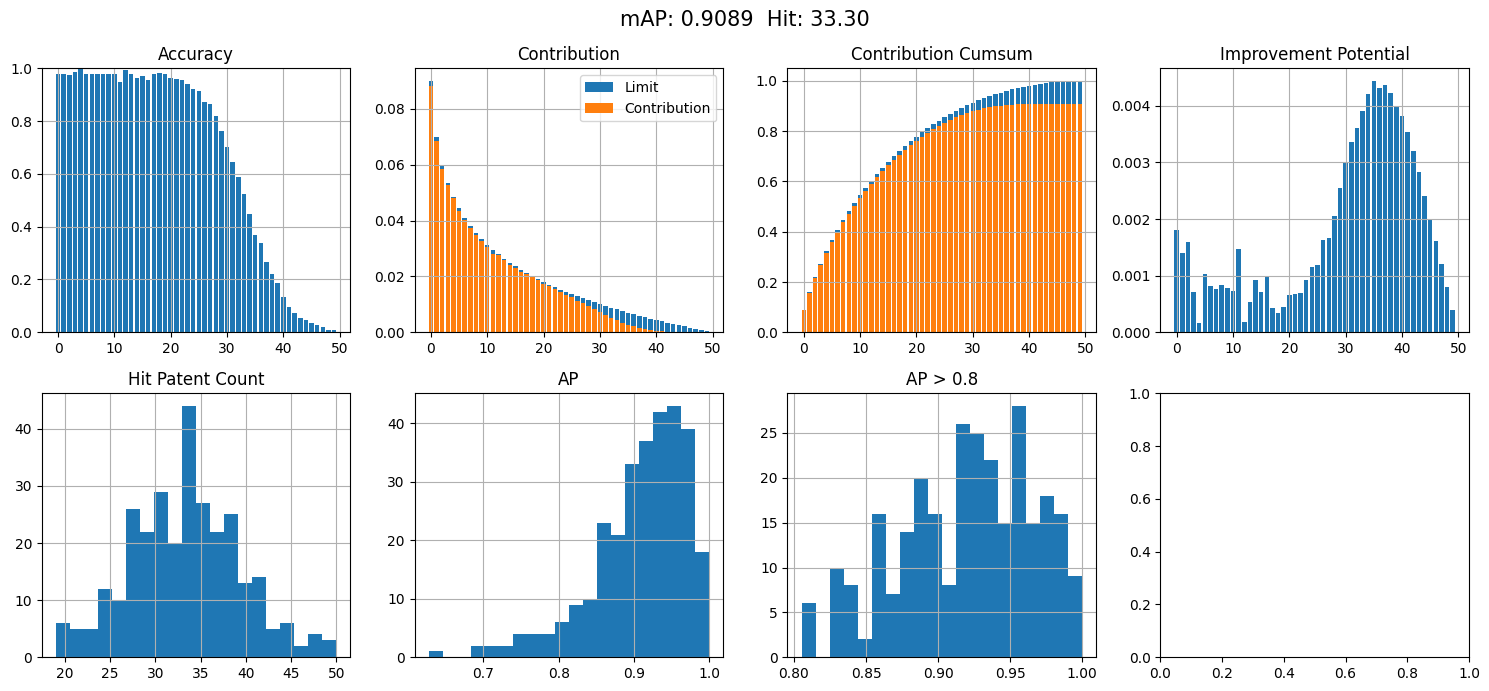

In [12]:
# 最適化
problems = []
for target_ids in tqdm(train.iter_rows(), desc="Generate Problems"):
    problem = Problem(target_ids)
    problems.append(problem)

queries, counts, aps = solve_problems(problems)
print("== SA Result ==")
print("AP:", np.mean(aps))
print("Count:", np.mean(counts))

# 評価
if TRAIN_MODE:
    print("== Evaluation ==")
    all_results = []
    for query in tqdm(queries):
        results = whoosh_utils.execute_query(query, qp, searcher)
        all_results.append(results)
    aps = evaluate(all_results, list(train.iter_rows()))

In [13]:
# submit
train = train.with_columns(pl.Series("query", queries)).select(["publication_number", "query"])
train.write_csv("submission.csv")
train.head(1)

publication_number,query
str,str
"""US-2011086809-…","""(cpc:A23L1/300…"
